In [1]:
from sys import path
path.append('../src/')

import os
import mlflow
import mlflow.keras
import numpy as np
import pickle as pkl
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
from os.path import join
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from skmultilearn.model_selection import iterative_train_test_split

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Fine-tuning'

In [3]:
PATH_TO_ROOT = '..'

FOLDER_MODELS = join(PATH_TO_ROOT, 'models/unsupervised_supervised/')
FILE_BASE_MODEL = join(FOLDER_MODELS, 'model_2020_07_12-02_22_54.h5')
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)

print(FOLDER_MODELS)
print(FILE_BASE_MODEL)
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)

..\models/unsupervised_supervised/
..\models/unsupervised_supervised/model_2020_07_12-02_22_54.h5
..\data/cropped_faces/cropped_faces_images.pkl
..\data/cropped_faces/cropped_faces_mrks.pkl


In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def compute_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes, y)
    class_weights = dict(zip(classes, weights))
    return class_weights

def get_output_counts(output_names, y):
    output_counts = [np.unique(y[:, i], return_counts=True) for i in range(y.shape[1])]
    output_prop = [(unique, counts / counts.sum()) for unique, counts in output_counts]

    dict_counts = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_counts)}
    dict_props = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_prop)}
    return dict_counts, dict_props

# Load Data

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

y = np.array([mrk.photo_reqs.values() for mrk in mrks])

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)
print(y.shape, y.dtype)

(5731, 160, 160, 3) float32
(5731,) object
(5731, 23) int32


# Load Model

In [6]:
model = load_model(FILE_BASE_MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "ICAOnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Fine-tuning 

In [7]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx] / 255
x_val = x[x_val_idx] / 255

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(4573, 160, 160, 3) float32
(4573, 23) int32
(1158, 160, 160, 3) float32
(1158, 23) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4573 samples, validate on 1158 samples
Epoch 1/100
4573/4573 [==============================] - 21s 5ms/step - loss: 0.1616 - accuracy: 0.9337 - matthews_correlation_coefficient: 0.7881 - val_loss: 0.1244 - val_accuracy: 0.9525 - val_matthews_correlation_coefficient: 0.8337

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.83368, saving model to ..\models/unsupervised_supervised/fine_tuning_2020_08_09-12_38_30.h5
Epoch 2/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1590 - accuracy: 0.9350 - matthews_correlation_coefficient: 0.7922 - val_loss: 0.1233 - val_accuracy: 0.9522 - val_matthews_correlation_coefficient: 0.8322

Epoch 00002: val_matthews_correlation_coefficient did not improve from 0.83368
Epoch 3/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1558 - accuracy: 0.9363 - matthews_correlation_coefficient: 0.7967 - val_loss: 0.1293 - val_accuracy: 0.9497 - val_matthews_correlation_coefficient: 0.82

4573/4573 [==============================] - 18s 4ms/step - loss: 0.1422 - accuracy: 0.9405 - matthews_correlation_coefficient: 0.8111 - val_loss: 0.1241 - val_accuracy: 0.9530 - val_matthews_correlation_coefficient: 0.8361

Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.84051
Epoch 26/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1414 - accuracy: 0.9421 - matthews_correlation_coefficient: 0.8166 - val_loss: 0.1369 - val_accuracy: 0.9486 - val_matthews_correlation_coefficient: 0.8206

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.84051
Epoch 27/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1410 - accuracy: 0.9423 - matthews_correlation_coefficient: 0.8167 - val_loss: 0.1209 - val_accuracy: 0.9544 - val_matthews_correlation_coefficient: 0.8412

Epoch 00027: val_matthews_correlation_coefficient improved from 0.84051 to 0.84117, saving model to ..\models/unsupervised_supervised/fine_tu


Epoch 00050: val_matthews_correlation_coefficient did not improve from 0.84117
Epoch 51/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1342 - accuracy: 0.9449 - matthews_correlation_coefficient: 0.8257 - val_loss: 0.1232 - val_accuracy: 0.9529 - val_matthews_correlation_coefficient: 0.8358

Epoch 00051: val_matthews_correlation_coefficient did not improve from 0.84117
Epoch 52/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1328 - accuracy: 0.9451 - matthews_correlation_coefficient: 0.8262 - val_loss: 0.1367 - val_accuracy: 0.9495 - val_matthews_correlation_coefficient: 0.8252

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.84117
Epoch 53/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1351 - accuracy: 0.9437 - matthews_correlation_coefficient: 0.8212 - val_loss: 0.1354 - val_accuracy: 0.9494 - val_matthews_correlation_coefficient: 0.8242

Epoch 00053: val_matthews_correlation_coefficien


Epoch 00076: val_matthews_correlation_coefficient did not improve from 0.84117
Epoch 77/100
4573/4573 [==============================] - 18s 4ms/step - loss: 0.1276 - accuracy: 0.9477 - matthews_correlation_coefficient: 0.8352 - val_loss: 0.1242 - val_accuracy: 0.9531 - val_matthews_correlation_coefficient: 0.8380
Restoring model weights from the end of the best epoch

Epoch 00077: val_matthews_correlation_coefficient did not improve from 0.84117
Epoch 00077: early stopping


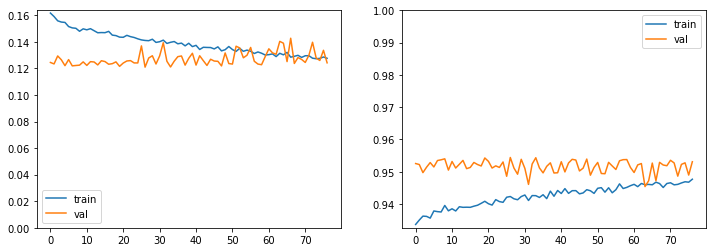

In [8]:
set_random_seeds()

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy', mcc]
)

metric_to_monitor = 'val_matthews_correlation_coefficient'
FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix='fine_tuning_')

list_callbacks = [
    EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
    ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
]

class_weights = [compute_class_weights(y_train[:, i]) for i in range(y_train.shape[1])]

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

hist = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=32, 
    epochs=100, 
    validation_data=(x_val, y_val),
    callbacks=list_callbacks,
    verbose=1,
    class_weight=class_weights,
)
plot.keras_hist(hist.history)

mlflow.end_run()

# Test 

In [15]:
import cv2

list_files = ['../data/cropped_faces/images/AR_FDB_m-013-17.png']

im = load.images_from_list_files(list_files, output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

1 of 1


In [16]:
y_pred = model.predict(im)
for pred in y_pred:
    print(pred)

[0.99987984 0.24505976 0.99992967 0.99345773 0.9979755  0.9999273
 0.86117923 0.739219   0.0842917  0.14188316 0.9081532  0.99998903
 0.04818597 0.9911523  0.9900096  0.99967575 0.7937765  1.
 0.97835696 0.9999519  0.9532324  0.00717809 0.99999917]


In [17]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

model_recompiled = load_model(FILE_MODEL, custom_objects=custom_objects)
model_recompiled.compile(optimizer=Adam(), loss='binary_crossentropy')
model_recompiled.save(FILE_MODEL)

y_pred_1 = model.predict(x_val)
y_pred_2 = model_recompiled.predict(x_val)

assert(np.allclose(y_pred_1, y_pred_2))

In [18]:
merged_model = load_model(FILE_MODEL)
y_pred = merged_model.predict(im)
for pred in y_pred[0]:
    print(pred)

0.99987984
0.24505976
0.99992967
0.99345773
0.9979755
0.9999273
0.86117923
0.739219
0.0842917
0.14188316
0.9081532
0.99998903
0.048185974
0.9911523
0.9900096
0.99967575
0.7937765
1.0
0.97835696
0.9999519
0.9532324
0.0071780877
0.99999917
